### *Code Cell — Imports & Settings*

In [1]:
# Core
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt

# Modeling / Stats (for RFM/CLV utility and ARIMA demo)
from statsmodels.tsa.arima.model import ARIMA

# Display settings
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

### *Code Cell — Load Data*

In [10]:
# Edit the path if needed
file_path = r"C:\Users\HP\Documents\Project_Datasets\Superstore Dataset.xlsx"  # <- update if different
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name="Superstore")

print(df.shape)
df.head()

(9800, 18)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-08-11 00:00:00,2017-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,"42,420.0000",South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-08-11 00:00:00,2017-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,"42,420.0000",South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-12-06 00:00:00,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,"90,036.0000",West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-11-10 00:00:00,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,"33,311.0000",South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-11-10 00:00:00,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,"33,311.0000",South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


### *Code Cell — Clean Dates, Postal Code, Duplicates, Tidy Names*

In [11]:
# 1) Parse dates safely
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df["Ship Date"]  = pd.to_datetime(df["Ship Date"],  errors="coerce")

# 2) Postal Code: fill missing with 0, cast to int
if "Postal Code" in df.columns:
    df["Postal Code"] = df["Postal Code"].fillna(0).astype(int)

# 3) Drop a pure index column if present
if "Row ID" in df.columns:
    df.drop(columns=["Row ID"], inplace=True, errors="ignore")

# 4) Consistent name formatting
if "Customer Name" in df.columns:
    df["Customer Name"] = df["Customer Name"].astype(str).str.strip().str.title()

# 5) Remove perfect duplicates
before = len(df)
df = df.drop_duplicates()
after = len(df)

print(f"Rows before: {before:,} | after: {after:,}")
df.info()

Rows before: 9,800 | after: 9,799
<class 'pandas.core.frame.DataFrame'>
Index: 9799 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9799 non-null   object        
 1   Order Date     9799 non-null   datetime64[ns]
 2   Ship Date      9799 non-null   datetime64[ns]
 3   Ship Mode      9799 non-null   object        
 4   Customer ID    9799 non-null   object        
 5   Customer Name  9799 non-null   object        
 6   Segment        9799 non-null   object        
 7   Country        9799 non-null   object        
 8   City           9799 non-null   object        
 9   State          9799 non-null   object        
 10  Postal Code    9799 non-null   int32         
 11  Region         9799 non-null   object        
 12  Product ID     9799 non-null   object        
 13  Category       9799 non-null   object        
 14  Sub-Category   9799 non-null   object      

### *Code Cell — Sales by Region*

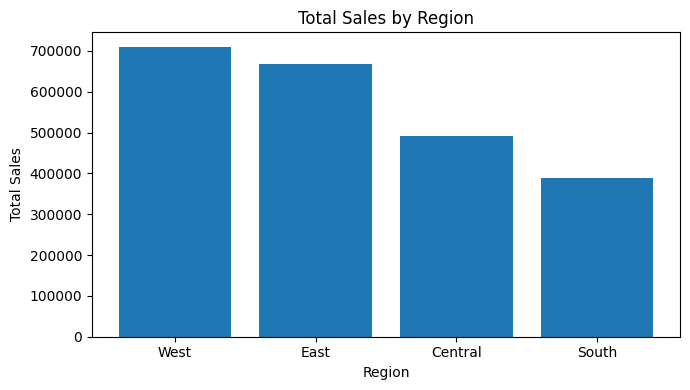

In [12]:
sales_by_region = (
    df.groupby("Region", as_index=False)["Sales"]
      .sum()
      .sort_values("Sales", ascending=False)
)

sales_by_region

# Visual
plt.figure(figsize=(7,4))
plt.bar(sales_by_region["Region"], sales_by_region["Sales"])
plt.title("Total Sales by Region")
plt.xlabel("Region"); plt.ylabel("Total Sales")
plt.tight_layout(); plt.show()

### *Code Cell — Which Years Are Present?*

In [13]:
years = sorted(df["Order Date"].dt.year.dropna().unique().astype(int))
years

[2015, 2016, 2017, 2018]

### *Code Cell — Helper: Peak Month per Region for a Year*


=== 2015 ===


,Region,Month,Sales
0,South,3,"33,368.8160"
1,East,11,"26,924.7810"
2,West,12,"23,952.4105"
3,Central,9,"18,395.2148"



=== 2016 ===


,Region,Month,Sales
0,East,9,"30,973.3800"
1,West,12,"16,363.6340"
2,Central,12,"15,135.9742"
3,South,9,"12,980.6510"



=== 2017 ===


,Region,Month,Sales
0,West,10,"25,595.1340"
1,Central,2,"24,273.9220"
2,East,1,"20,835.7120"
3,South,5,"18,248.8910"



=== 2018 ===


,Region,Month,Sales
0,West,3,"40,542.3160"
1,East,11,"37,245.6060"
2,Central,1,"19,973.7360"
3,South,4,"15,147.3340"


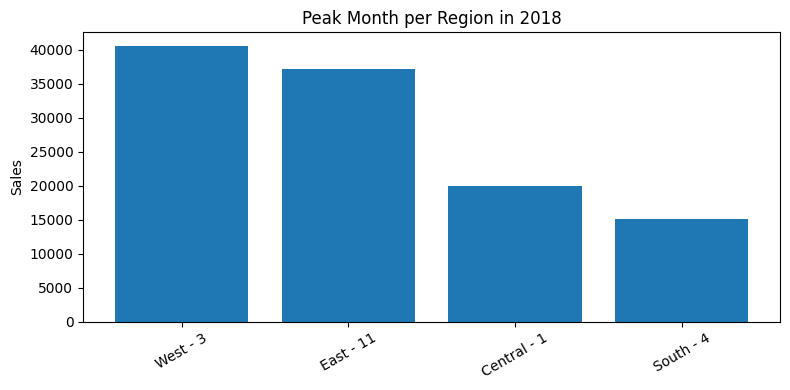

In [15]:
def peak_month_per_region_for_year(data, year):
    temp = data[data["Order Date"].dt.year == year].copy()
    temp["Month"] = temp["Order Date"].dt.month
    g = temp.groupby(["Region","Month"], as_index=False)["Sales"].sum()
    idx = g.groupby("Region")["Sales"].idxmax()
    peaks = g.loc[idx].sort_values("Sales", ascending=False).reset_index(drop=True)
    return peaks

for y in years:
    print(f"\n=== {y} ===")
    display(peak_month_per_region_for_year(df, y))

# visualize latest year’s peaks
latest_year = years[-1]
peaks = peak_month_per_region_for_year(df, latest_year)

labels = peaks["Region"] + " - " + peaks["Month"].astype(str)
plt.figure(figsize=(8,4))
plt.bar(labels, peaks["Sales"])
plt.title(f"Peak Month per Region in {latest_year}")
plt.xticks(rotation=30); plt.ylabel("Sales")
plt.tight_layout(); plt.show()

### *Code Cell — Sales by Category & Sub-Category*

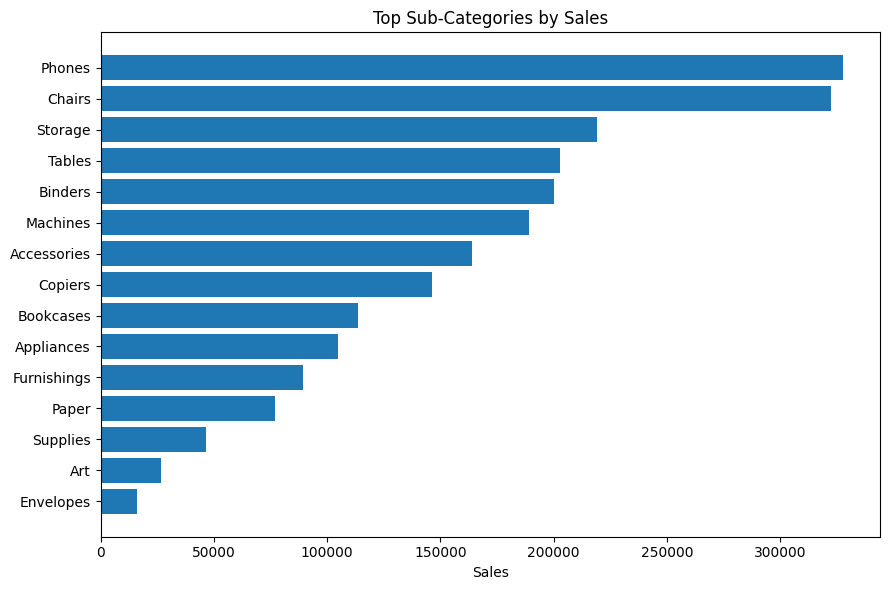

In [16]:
sales_cat_sub = (
    df.groupby(["Category","Sub-Category"], as_index=False)["Sales"].sum()
      .sort_values(["Category","Sales"], ascending=[True, False])
)

sales_cat_sub.head(10)

# Visual: top sub-categories overall
top_sub = sales_cat_sub.sort_values("Sales", ascending=False).head(15)
plt.figure(figsize=(9,6))
plt.barh(top_sub["Sub-Category"], top_sub["Sales"])
plt.gca().invert_yaxis()
plt.title("Top Sub-Categories by Sales")
plt.xlabel("Sales")
plt.tight_layout(); plt.show()

### *Code Cell — Per-Month Top Sub-Category (by Year)*

In [17]:
def top_subcategory_each_month(data, year):
    t = data[data["Order Date"].dt.year == year].copy()
    t["Month"] = t["Order Date"].dt.month
    g = t.groupby(["Month","Sub-Category"], as_index=False)["Sales"].sum()
    idx = g.groupby("Month")["Sales"].idxmax()
    topm = g.loc[idx].sort_values("Month").reset_index(drop=True)
    return topm

for y in years:
    print(f"\n=== {y} ===")
    display(top_subcategory_each_month(df, y))


=== 2015 ===


,Month,Sub-Category,Sales
0,1,Chairs,"9,461.2920"
1,2,Phones,"2,871.7640"
2,3,Machines,"25,314.6580"
3,4,Machines,"4,727.9160"
4,5,Phones,"4,877.6900"
5,6,Chairs,"6,750.5370"
6,7,Supplies,"8,311.9420"
7,8,Machines,"8,369.9220"
8,9,Machines,"13,021.1200"
9,10,Phones,"9,580.9220"



=== 2016 ===


,Month,Sub-Category,Sales
0,1,Chairs,"8,644.0220"
1,2,Chairs,"4,183.8680"
2,3,Binders,"7,947.4930"
3,4,Phones,"9,211.8480"
4,5,Chairs,"8,237.7480"
5,6,Binders,"5,003.5720"
6,7,Chairs,"6,793.9520"
7,8,Phones,"8,980.1820"
8,9,Phones,"11,979.6700"
9,10,Chairs,"6,582.1040"



=== 2017 ===


,Month,Sub-Category,Sales
0,1,Binders,"6,130.3840"
1,2,Copiers,"18,499.9300"
2,3,Supplies,"8,868.0120"
3,4,Machines,"11,136.1800"
4,5,Chairs,"10,103.1460"
5,6,Phones,"9,759.9440"
6,7,Chairs,"5,874.6880"
7,8,Phones,"8,720.2100"
8,9,Chairs,"8,239.0570"
9,10,Phones,"10,730.9440"



=== 2018 ===


,Month,Sub-Category,Sales
0,1,Phones,"9,380.1000"
1,2,Phones,"8,970.9980"
2,3,Copiers,"21,799.8220"
3,4,Machines,"11,198.9650"
4,5,Phones,"6,683.7460"
5,6,Phones,"8,181.7940"
6,7,Phones,"12,291.2760"
7,8,Binders,"15,263.5700"
8,9,Chairs,"13,649.4500"
9,10,Copiers,"11,199.9680"


### *Code Cell — Top Sub-Category by Region (Overall & by Year)*

In [18]:
def top_sub_by_region(data):
    g = data.groupby(["Region","Sub-Category"], as_index=False)["Sales"].sum()
    idx = g.groupby("Region")["Sales"].idxmax()
    return g.loc[idx].reset_index(drop=True)

print("Overall:")
display(top_sub_by_region(df))

for y in years:
    print(f"\n=== {y} ===")
    d = df[df["Order Date"].dt.year == y]
    display(top_sub_by_region(d))

Overall:


,Region,Sub-Category,Sales
0,Central,Chairs,"82,372.7760"
1,East,Phones,"99,884.6620"
2,South,Phones,"58,098.3380"
3,West,Chairs,"100,023.2000"



=== 2015 ===


,Region,Sub-Category,Sales
0,Central,Chairs,"20,754.0520"
1,East,Chairs,"21,726.8960"
2,South,Machines,"27,594.7250"
3,West,Phones,"29,527.4400"



=== 2016 ===


,Region,Sub-Category,Sales
0,Central,Phones,"19,363.9220"
1,East,Phones,"22,118.3180"
2,South,Binders,"13,329.4930"
3,West,Chairs,"22,620.1600"



=== 2017 ===


,Region,Sub-Category,Sales
0,Central,Chairs,"22,417.6340"
1,East,Machines,"25,215.9380"
2,South,Machines,"13,238.6000"
3,West,Chairs,"30,744.2800"



=== 2018 ===


,Region,Sub-Category,Sales
0,Central,Phones,"23,143.3560"
1,East,Phones,"35,952.1880"
2,South,Phones,"21,157.1700"
3,West,Copiers,"29,459.6760"


### *Code Cell — Top 10 Customers & Their Preferred Sub-Category*

In [19]:
top10 = (
    df.groupby("Customer Name", as_index=False)["Sales"].sum()
      .sort_values("Sales", ascending=False)
      .head(10)
)

top10

# Preferred sub-category per top customer
sub_pref = (
    df[df["Customer Name"].isin(top10["Customer Name"])]
      .groupby(["Customer Name","Sub-Category"], as_index=False)["Sales"].sum()
)

idx = sub_pref.groupby("Customer Name")["Sales"].idxmax()
top10_pref = sub_pref.loc[idx].sort_values("Sales", ascending=False).reset_index(drop=True)
top10_pref

,Customer Name,Sub-Category,Sales
0,Sean Miller,Machines,"23,459.7800"
1,Tamara Chand,Copiers,"17,499.9500"
2,Raymond Buch,Copiers,"13,999.9600"
3,Sanjit Chand,Binders,"11,468.1660"
4,Tom Ashbrook,Copiers,"11,199.9680"
5,Christopher Conant,Copiers,"11,199.9360"
6,Adrian Barton,Binders,"11,068.9100"
7,Hunter Lopez,Copiers,"10,499.9700"
8,Sanjit Engle,Machines,"8,749.9500"
9,Ken Lonsdale,Supplies,"8,187.6500"


### *Code Cell — Monthly & Yearly Sales Trends*

In [24]:
# Extract year and month
df["Year"] = df["Order Date"].dt.year
df["Month"] = df["Order Date"].dt.month

# Monthly aggregation
monthly = (df
           .groupby(df["Order Date"].dt.to_period("M"))["Sales"]
           .sum()
           .reset_index()
           .rename(columns={"Order Date":"YearMonth"}))

# Convert to timestamp if needed
if monthly["YearMonth"].dtype.name == "period[M]":
    monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()

# Yearly aggregation
yearly = df.groupby("Year", as_index=False)["Sales"].sum()

display(monthly.head())
display(yearly)

,YearMonth,Sales
0,2015-01-01,"28,828.2540"
1,2015-02-01,"12,588.4840"
2,2015-03-01,"54,027.6920"
3,2015-04-01,"24,428.6440"
4,2015-05-01,"29,520.4900"


,Year,Sales
0,2015,"479,574.8361"
1,2016,"459,436.0054"
2,2017,"600,192.5500"
3,2018,"722,052.0192"


### *Code Cell — RFM Scoring (Recency, Frequency, Monetary)*

In [25]:
latest_date = df["Order Date"].max()

# Recency (days since last order)
recency = df.groupby("Customer ID", as_index=False)["Order Date"].max()
recency["Recency"] = (latest_date - recency["Order Date"]).dt.days

# Frequency (# of unique orders)
frequency = df.groupby("Customer ID", as_index=False)["Order ID"].nunique().rename(columns={"Order ID":"Frequency"})

# Monetary (total spend)
monetary = df.groupby("Customer ID", as_index=False)["Sales"].sum().rename(columns={"Sales":"Monetary"})

rfm = recency.merge(frequency, on="Customer ID").merge(monetary, on="Customer ID")

# Quantile scores (1–4): adjust labels if you want 1=best for Recency
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])  # lower recency (more recent) → higher score
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"],  4, labels=[1,2,3,4])

rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()

,Customer ID,Order Date,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,AA-10315,2018-06-29,184,5,"5,563.5600",2,2,4,224
1,AA-10375,2018-11-12,48,9,"1,056.3900",3,4,1,341
2,AA-10480,2018-04-15,259,4,"1,790.5120",1,1,2,112
3,AA-10645,2018-05-11,233,6,"5,086.9350",1,2,4,124
4,AB-10015,2017-10-11,445,3,886.1560,1,1,1,111


### *Code Cell — Simple CLV Segmentation (Assumptions Explained)*

In [29]:
# Simple, transparent CLV approximation (for demo):
# Avg Order Value per customer
rfm["Avg_Order_Value"] = rfm["Monetary"] / rfm["Frequency"].replace(0, np.nan)

# Portfolio-level purchase frequency (orders per customer)
portfolio_freq = rfm["Frequency"].sum() / len(rfm)

# Assumptions: annual churn ~ 1/365 per day horizon; gross margin ~ 5%
churn_rate  = 1 / 365
gross_margin = 0.05

rfm["CLV"] = (rfm["Avg_Order_Value"] * portfolio_freq) / churn_rate * gross_margin

# Quartiles into segments
rfm["CLV_Segment"] = pd.qcut(rfm["CLV"], 4, labels=["Low","Medium","High","Top"])

rfm[["Customer ID","CLV","CLV_Segment"]].head()

# Quick distribution
seg_counts = rfm["CLV_Segment"].value_counts()
seg_counts

CLV_Segment
Low       199
Medium    198
High      198
Top       198
Name: count, dtype: int64

### *Code Cell — Shipping Mode Sales + Preference of Top-Value Customers*

In [30]:
# Overall sales by ship mode
ship_sales = df.groupby("Ship Mode", as_index=False)["Sales"].sum().sort_values("Sales", ascending=False)
display(ship_sales)

# Among top CLV customers
top_ids = rfm.loc[rfm["CLV_Segment"]=="Top", "Customer ID"]
ship_sales_top = (
    df[df["Customer ID"].isin(top_ids)]
      .groupby("Ship Mode", as_index=False)["Sales"].sum()
      .sort_values("Sales", ascending=False)
)
display(ship_sales_top)

,Ship Mode,Sales
3,Standard Class,"1,340,549.9350"
2,Second Class,"449,914.1794"
0,First Class,"345,572.2573"
1,Same Day,"125,219.0390"


,Ship Mode,Sales
3,Standard Class,"706,259.7978"
2,Second Class,"218,961.3893"
0,First Class,"177,444.3047"
1,Same Day,"53,473.6280"


### *Code Cell — Quick Forecast (ARIMA) for a Sub-Category*

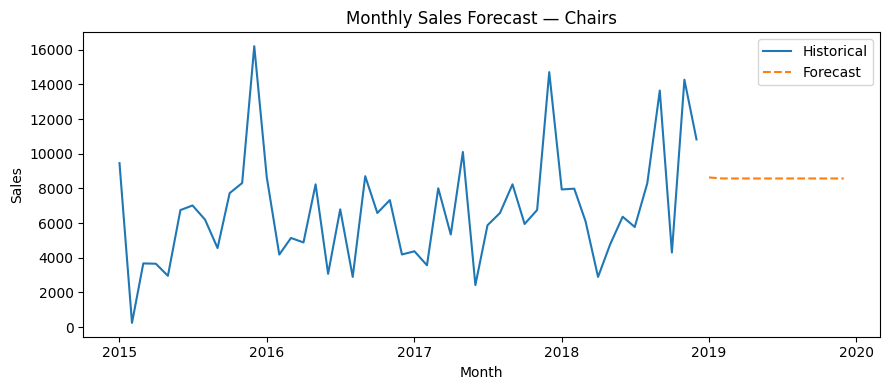

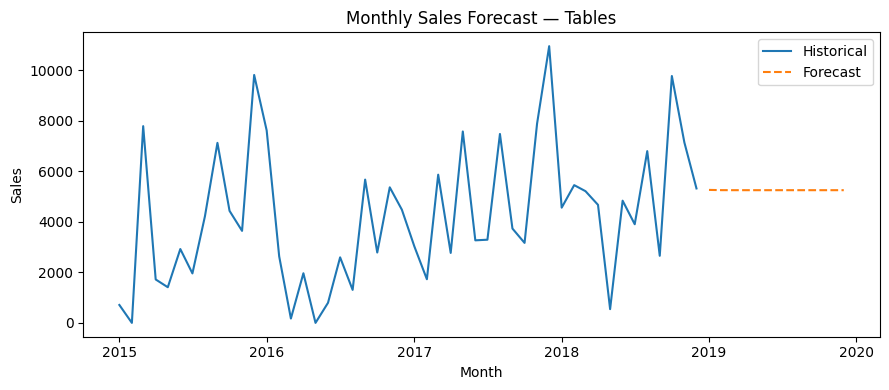

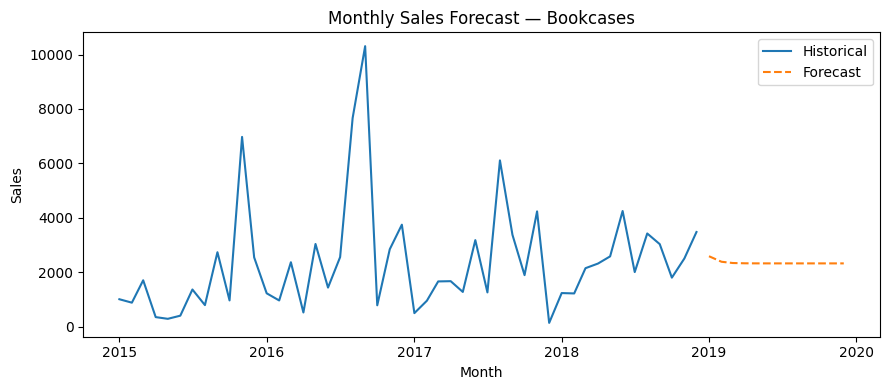

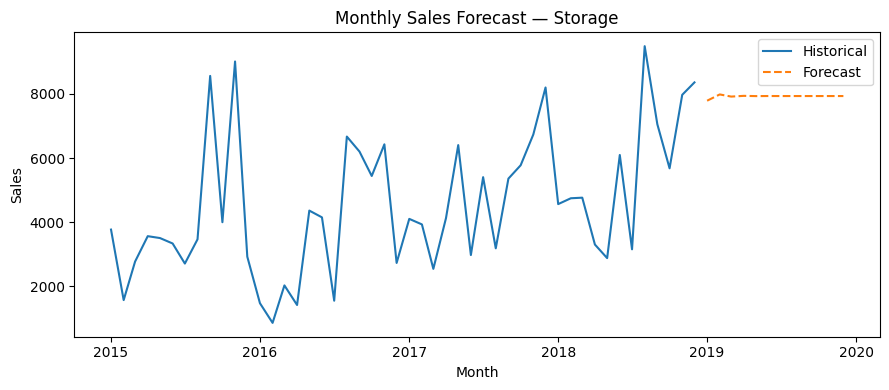

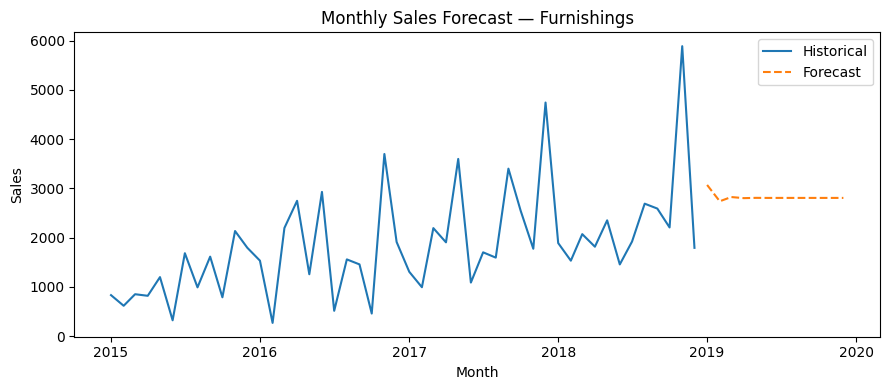

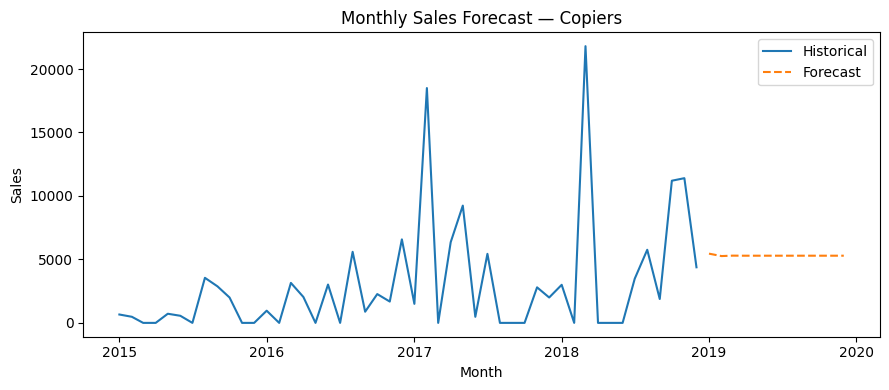

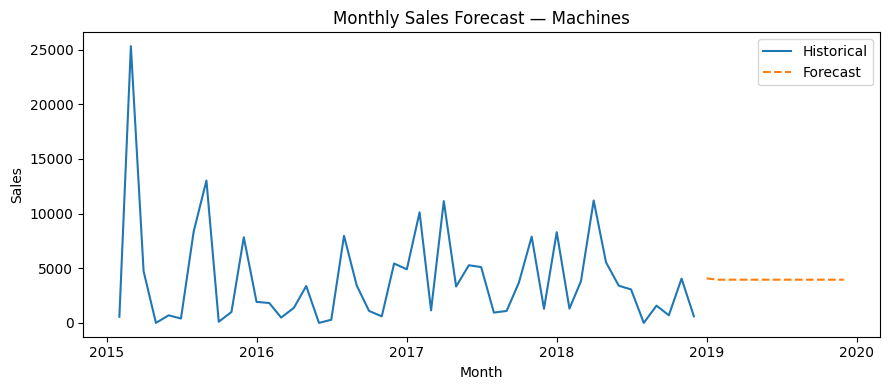

In [31]:
def forecast_subcategory(data, subcat, steps=12, order=(1,1,1)):
    # Monthly sales series
    s = (data[data["Sub-Category"]==subcat]
         .set_index("Order Date")
         .resample("MS")["Sales"].sum()
         .asfreq("MS").fillna(0))
    
    # Fit a simple ARIMA (demo-level)
    model = ARIMA(s, order=order)
    fit = model.fit()
    fc = fit.forecast(steps=steps)

    # Plot
    plt.figure(figsize=(9,4))
    plt.plot(s.index, s.values, label="Historical")
    plt.plot(fc.index, fc.values, linestyle="--", label="Forecast")
    plt.title(f"Monthly Sales Forecast — {subcat}")
    plt.xlabel("Month"); plt.ylabel("Sales")
    plt.legend(); plt.tight_layout(); plt.show()
    return fit, fc

# Example categories you highlighted in your analysis:
for sub in ["Chairs","Tables","Bookcases","Storage","Furnishings","Copiers","Machines"]:
    try:
        forecast_subcategory(df, sub)
    except Exception as e:
        print(sub, "→", e)